# 2a Features Extraction

Runs:
- Imports & Functions [Jump To](#run-0-all-imports-etc)
- Study Load & Inspections [Jump To](#run-1-study-load--inspections)
- Feature Selection [Jump To](#run-2-feature-selections)

To Do:
- ?? Rejection of channels, subjects ....
- ?? Use of canonical bands
- Data prep, save data results for ML training / ML Execution .... or pipeline rerun?

# Imports & Functions

## Imports

In [1]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier

## Results & Features Inspection

In [2]:
# Plots for subject info
#

def subject_info_plot(subjects_df):

    # PD & Gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - PD & Gender', fontsize=18)

    counts = subjects_df['pd'].value_counts()
    axes[0].set_title('PD')
    axes[0].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    counts = subjects_df['gender'].value_counts()
    axes[1].set_title('Gender')
    axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[1].set_xticks(range(len(counts.index)))
    axes[1].set_xticklabels(['Male', 'Female'])
    for i, (label, count) in enumerate(counts.items()):
        axes[1].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Age Distribution & Box
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - Age Distribution', fontsize=18)

    axes[0].hist(subjects_df['age'], bins=15, color='skyblue', edgecolor='black')

    axes[1].set_xticks([0])
    box = axes[1].boxplot(subjects_df['age'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [3]:
# Plots for EEG Preprocessing Results
#

def eeg_preprocess_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG Preprocessing Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['EEG_preprocessing_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # # Channels count
    # counts = results_df['channel_count'].value_counts()
    # axes[1].set_title('Channels Count')
    # axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue'], edgecolor='black')

    # ICA Rejection Level
    axes[1].set_title('ICA - ICs Rejection Level')
    box = axes[1].boxplot(results_df['ICA_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Epoch Rejection Level
    axes[2].set_title('Epoch Rejection Level')
    box = axes[2].boxplot(results_df['epoch_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')
    # axes[2].set_xlabel('Epoch Rejection Level')
    # axes[2].set_ylabel('Number of Subjects')
    # axes[2].hist(results_df['epoch_rejection_level'], bins=10, color='skyblue', edgecolor='black')
    # nonzero_epoch_rejection = results_df['epoch_rejection_level'][results_df['epoch_rejection_level'] > 0]
    # axes[2].hist(nonzero_epoch_rejection, bins=15, color='salmon', edgecolor='black', alpha=0.7)
    # for bar in axes[2].patches:
    #     bar.set_width(bar.get_width() * 0.8)

    plt.tight_layout()
    plt.show()


In [4]:
# Plots for EEG SpecParam Results
#

def eeg_specparam_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG SpecParam Fit Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['chn_SPM_fit_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # Error Mean
    axes[1].set_title('Error Mean')
    box = axes[1].boxplot(results_df['chn_error_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # R-Squared Mean
    axes[2].set_title('R2 Mean')
    box = axes[2].boxplot(results_df['chn_r2_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()

    # Number of flagged channels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))
    # fig.suptitle('EEG SpecParam Fit Metrics - Flagged Channels', fontsize=18)
    flagged_counts = results_df['chn_flagged_channels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes.set_title('Flagged Channels Count')
    box = axes.boxplot(flagged_counts, patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='salmon')

    plt.tight_layout()
    plt.show()

# Run: 0. All Imports etc

In [5]:
# Dummy - Run All above

# Run: 1. Study Load & Inspections

In [6]:
# Study and Processing Run Details

#---- Parameters --------------------------------
# Study & Processing Run Details
study_name = 'IOWA_Rest'
eeg_features_run = '1b_EEG_Features_Results_Run_20250724_full_run'

run_description = 'test_extraction'
test_mode = True

# Extraction Parameters
extraction_params = {'features_detail_level': 'region',    # region or channel, default channels
                     'subject_meta_include': False,
                     'aperiodic_include': False,
                     'periodic_include': True
                    }
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')

# Setup the extraction run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'2a_Feature_Extraction_Data_Run_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['ml_training_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'study_name': study_name,
    'run_name': run_name,
    'extraction_params': extraction_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    TEST_SUBJECTS = [0,5,101]
    # TEST_CHANNELS = ['F5', 'C3', 'P3', 'F6', 'C6', 'P6']
else:
    VERBOSE = False
    TEST_SUBJECTS = []
    # TEST_CHANNELS = []

EEG Processing Parameters
- Study: IOWA_Rest ds004584-1.0.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250724_full_ica
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250724_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
- Features Extraction Run: 2a_Feature_Extraction_Data_Run_20250731_test_extraction
-   Feature Extraction Params: {'features_detail_level': 'region', 'subject_meta_include': False, 'aperiodic_include': False, 'periodic_include': True}

EEG Processing Results
(149, 23)


,subject_id,EEG_preprocessing_quality_warning,channel_count,ICA_components_count,ICA_rejection_level,epochs_count,epoch_rejection_level,reg_SPM_fit_quality_warning,reg_spectra_count,reg_null_fits,...,reg_peaks_count_max,reg_peaks_count_mean,chn_SPM_fit_quality_warning,chn_spectra_count,chn_null_fits,chn_error_mean,chn_r2_mean,chn_flagged_channels,chn_peaks_count_max,chn_peaks_count_mean
0,sub-001,False,63,62,0.467742,281,0.0,False,3,0,...,2,2.0,True,63,0,0.042768,0.920499,[33],4,2.190476
1,sub-002,False,63,62,0.064516,326,0.0,False,3,0,...,3,2.333333,True,63,0,0.057373,0.976498,"[10, 20, 52]",3,1.444444
2,sub-003,False,63,62,0.080645,243,0.0,True,3,0,...,1,1.0,True,63,0,0.11217,0.94776,"[0, 2, 3, 11, 14, 26, 28, 31, 32, 33, 35, 42, ...",4,1.920635
3,sub-004,False,63,62,0.129032,263,0.079848,False,3,0,...,2,1.333333,True,63,0,0.079636,0.976364,"[5, 15, 16, 28, 30, 32, 33, 58, 61]",3,1.301587
4,sub-005,False,63,62,0.274194,246,0.02439,True,3,0,...,3,3.0,True,63,0,0.06269,0.755602,[],4,2.698413


Null Fits: 0


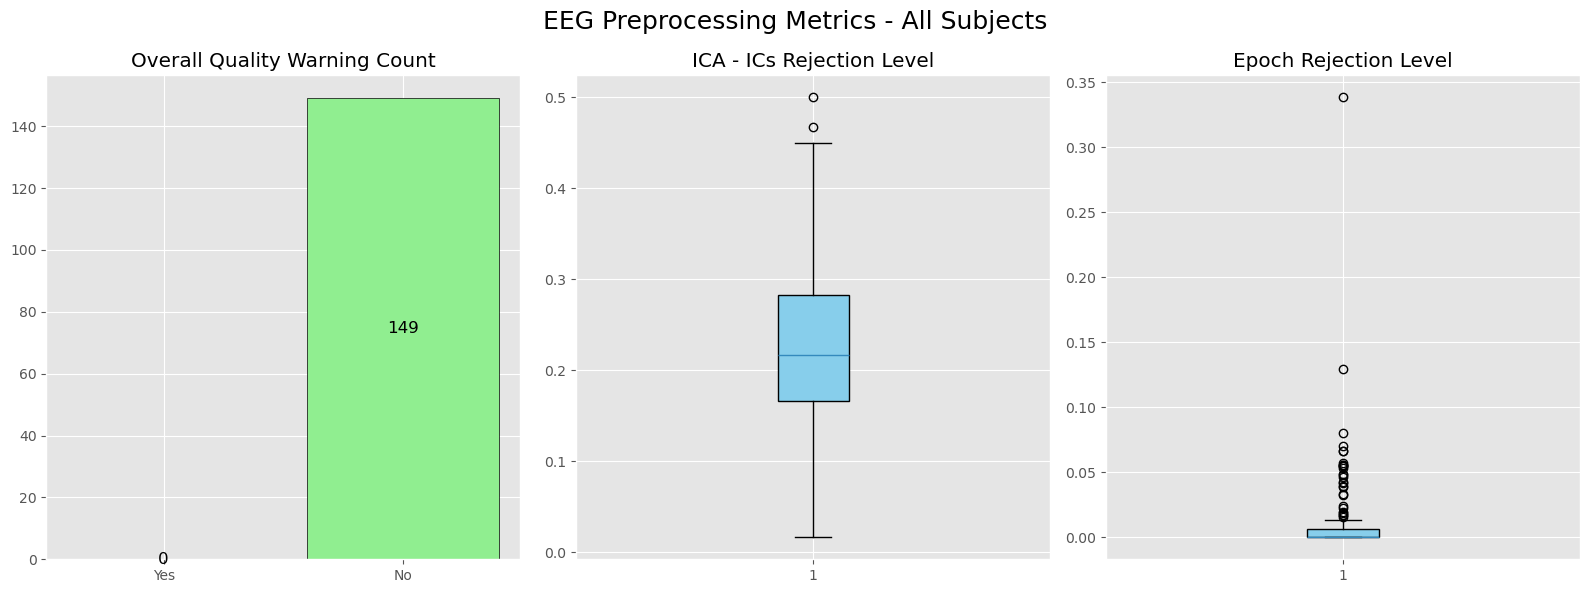

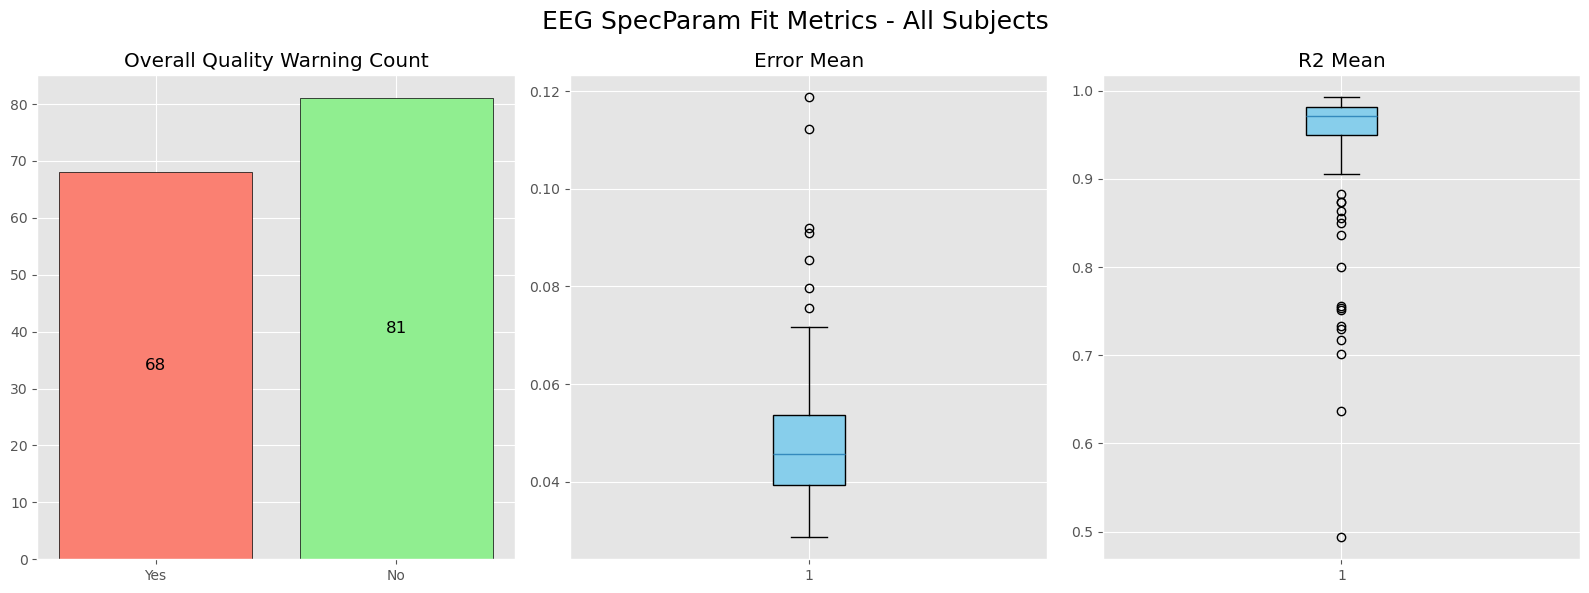

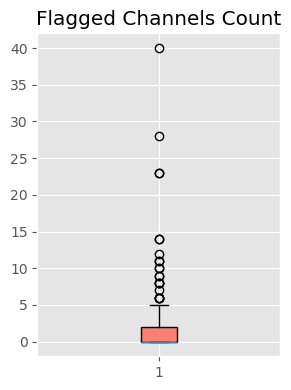

In [7]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Extraction Run: {run_name}"
summary = summary + f"\n-   Feature Extraction Params: {run_details['extraction_params']}"
print(f'{summary}\n')

# Processing Metrics
print('EEG Processing Results')
print(eeg_processing_results_df.shape)
display(eeg_processing_results_df.head())

print(f'Null Fits: {sum(eeg_processing_results_df["chn_null_fits"])}')
eeg_preprocess_results_plot(eeg_processing_results_df)
eeg_specparam_results_plot(eeg_processing_results_df)


Study Subjects
(149, 5)


,study_name,subject_id,pd,age,gender
0,IOWA_Rest,sub-001,1,80,M
1,IOWA_Rest,sub-002,1,81,M
2,IOWA_Rest,sub-003,1,68,F
3,IOWA_Rest,sub-004,1,80,M
4,IOWA_Rest,sub-005,1,56,M


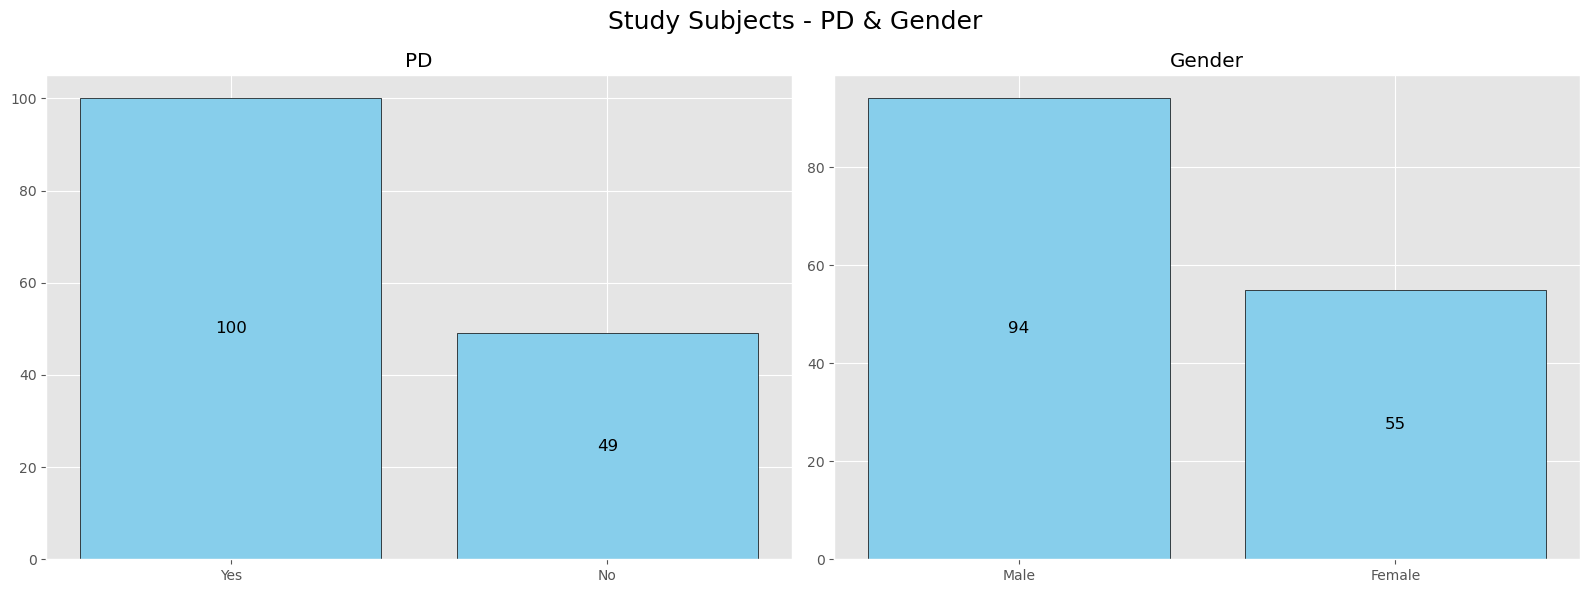

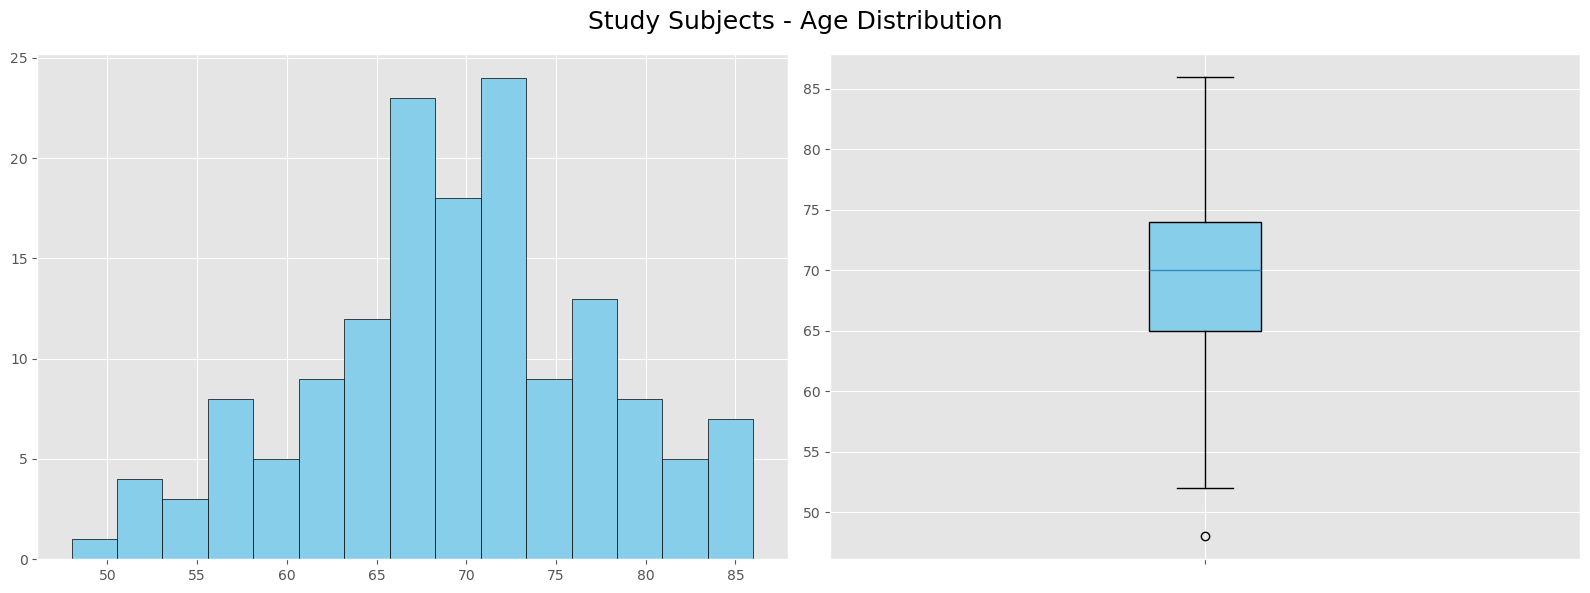

In [8]:
# Study Subjects Summary
print('Study Subjects')
print(study_subjects_df.shape)
display(study_subjects_df.head())

subject_info_plot(study_subjects_df)

In [9]:
# Features Superset 
print('EEG Features Superset')
print(eeg_features_superset_df.shape)
display(eeg_features_superset_df.head())


EEG Features Superset
(9556, 24)


,subject_id,channel,offset,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,...,pw_3,bw_3,cf_4,pw_4,bw_4,cf_5,pw_5,bw_5,error,r_squared
0,sub-001,frontal,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,0.279289,7.943160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034690,0.944893
1,sub-001,central,-13.225069,0.001710,6.783147,0.275626,2.065892,24.000274,0.400991,8.363863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042600,0.831166
2,sub-001,posterior,-11.600760,1.001592,7.041851,0.623959,3.047822,10.205950,0.359989,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035003,0.990475
3,sub-001,Fp1,-12.200923,0.073338,5.000001,0.424577,6.068113,25.200637,0.384810,7.701297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076825,0.732550
4,sub-001,Fz,-11.761049,0.695183,6.972525,0.476730,3.088743,9.953165,0.262546,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029025,0.982654


In [10]:
# SpecParam Results

# TODO: Summary of features? What detail ............ 

# aperiodic_components_plot(eeg_features_superset_df)
# periodic_components_plot(eeg_features_superset_df)
# Adapt from xx Features Extraction, xx Model Training


# Temp Superset tidy up ... move to EEG extraction

In [11]:
# TODO: Temp fix, split the channels column into seperate region and channel ... Amend EEG Extract to do this directly
valid_regions = ['frontal', 'central', 'posterior']

eeg_features_superset_df['region'] = eeg_features_superset_df['channel'].where(
    eeg_features_superset_df['channel'].isin(valid_regions), np.nan)
eeg_features_superset_df.loc[eeg_features_superset_df['channel'].isin(valid_regions), 'channel'] = np.nan
cols = list(eeg_features_superset_df.columns)
cols.insert(cols.index('subject_id') + 1, cols.pop(cols.index('region')))
eeg_features_superset_df = eeg_features_superset_df[cols]


In [12]:
# TODO: Put at the end of the EEG extract to generate store initially
# Combine the subject 'meta' df and EEG features df
# With one row per subject and several hundred 'features'
#

def combine_subjects_features(subjects_df, features_df):
    non_feature_cols = ['subject_id', 'region', 'channel']

    subjects_features = []
    subjects = subjects_df['subject_id'].unique()
    if 'study_name' in subjects_df.columns:
        subjects_df = subjects_df.drop(columns=['study_name'])

    for subj_id in subjects:
        subj_meta_dict = subjects_df.loc[subjects_df['subject_id'] == subj_id].iloc[0].to_dict()
        subj_features_df = features_df[features_df['subject_id'] == subj_id]

        # Subject ID & Meta data
        row_dict = {'subject_id': subj_id}
        row_dict.update(subj_meta_dict)

        # Flattened Region & Channel data
        for _, next_row in subj_features_df.iterrows():
            region = next_row['region']
            channel = next_row['channel']
            prefix = f'region_{region}_' if pd.notna(region) else f'channel_{channel}_'
            for col in next_row.index:
                if col in non_feature_cols:
                    continue
                row_dict[f'{prefix}{col}'] = next_row[col]

        subjects_features.append(row_dict)
    
    combined_df = pd.DataFrame(subjects_features)
    return combined_df

subject_features_flattened_df = combine_subjects_features(study_subjects_df, eeg_features_superset_df)
print('Combined Flattened Features DataFrame')
print(subject_features_flattened_df.shape)
display(subject_features_flattened_df.head())

Combined Flattened Features DataFrame
(149, 1478)


,subject_id,pd,age,gender,region_frontal_offset,region_frontal_exponent,region_frontal_cf_0,region_frontal_pw_0,region_frontal_bw_0,region_frontal_cf_1,...,channel_Iz_pw_3,channel_Iz_bw_3,channel_Iz_cf_4,channel_Iz_pw_4,channel_Iz_bw_4,channel_Iz_cf_5,channel_Iz_pw_5,channel_Iz_bw_5,channel_Iz_error,channel_Iz_r_squared
0,sub-001,1,80,M,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-002,1,81,M,-10.770975,1.462089,6.318833,0.594900,2.065198,16.200240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-003,1,68,F,-11.282055,1.181536,11.545416,0.942409,12.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-004,1,80,M,-11.485494,1.369393,6.137473,0.844282,4.052694,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-005,1,56,M,-12.037372,0.511769,6.566139,0.435743,2.000000,13.261402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Run: 2. Feature Selection & Data Prep

In [13]:
# Separate X features and y target
# TODO: Separate notebook and load selected fetaures df?

target_col_name = 'pd'
feature_names = subject_features_flattened_df.columns[subject_features_flattened_df.columns != target_col_name]
X = subject_features_flattened_df[feature_names].copy()
y = subject_features_flattened_df[target_col_name].copy()

# Data Split : Training & Test, 80:20. NB cross-validation will be performed using Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Different split?
# split by *subjects*, not by raw rows
# train_subj, test_subj = train_test_split(subjects, stratify=labels,
#                                          test_size=.3, random_state=42)
# X_train = eeg_long[eeg_long.subject_id.isin(train_subj)]
# X_test  = eeg_long[eeg_long.subject_id.isin(test_subj)]
# y_train = labels.loc[train_subj].values
# y_test  = labels.loc[test_subj].values

In [14]:
# Feature Selection using a Custom Transformer class
#

# TODO: Add more sophisticated selection, eg PCA etc?
# TODO: ?? Evaluate feature selection in in a grid search 
# but with a static model to avoid huge permutations and running time

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self, features_detail_level='default', selected_features='default'):
        # Parameters for the selection
        self.features_detail_level = features_detail_level
        self.selected_features = selected_features

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Filter out features according to detail level, ie region or channel
        drop_cols =[]
        if self.features_detail_level == 'region':
            drop_cols = drop_cols + [col for col in X_temp_df.columns if col.startswith('channel')]
        elif self.features_detail_level == 'channel':
            drop_cols = drop_cols +[col for col in X_temp_df.columns if col.startswith('region')]
        else:
            raise ValueError(f'Detail of {self.features_detail_level} is not region or channel')
        X_temp_df = X_temp_df.drop(columns=drop_cols, errors='ignore')
        
        # Only retain columns whose names contain any of the selected features
        X_temp_df = X_temp_df[[col for col in X_temp_df.columns if any(feat in col for feat in self.selected_features)]]
       
        self.selected_features_ = list(X_temp_df)
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Apply feature selection
        return X[self.selected_features_]


In [15]:
# Features Selection & Cleaning Pipeline Establish & Train
#

# TODO: Compare no scaling at all and model performance
# TODO: Different scaling approaches?
# TODO: Save pipleline for later reuse alongside the trained ML model

# Transformer for Features Selection
detail_level = extraction_params['features_detail_level']

selected_features = []
if extraction_params['subject_meta_include']: selected_features += ['age', 'gender']
if extraction_params['aperiodic_include']: selected_features += ['offset', 'exponent']
if extraction_params['periodic_include']: selected_features += ['pw', 'bw', 'cf']
# metrics = ['error', 'r_squared']

feature_selector =  FeatureSelection(detail_level, selected_features)

# Sub pipeline for numerical and categorical transformations
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale_num', RobustScaler()) # TODO: vs standardscaler?
    ])
cat_pipeline = Pipeline([
    # ("impute", SimpleImputer(strategy="most_frequent")),
    # ("encode_cat", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ('encode_cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))
    ])
cols_transform = ColumnTransformer([
    ('numeric', num_pipeline, make_column_selector(dtype_include=['float64', 'int64'])),
    ('categorical', cat_pipeline, make_column_selector(dtype_include='object'))
])

# Setup & train/fit the overall pipeline
features_prep_pipeline = Pipeline([
    ('features_selection', feature_selector),
    # ('drop_columns', dropper),
    ('data_preprocess', cols_transform)
    ])  
features_prep_pipeline.fit(X_train)


/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/impute/_base.py:574: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


,steps,"[('features_selection', ...), ('data_preprocess', ...)]"
,transform_input,None
,memory,None
,verbose,False
,features_detail_level,'region'
,selected_features,"['pw', 'bw', ...]"
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [16]:
# Apply the transformations to training data

X_train_transformed = features_prep_pipeline.transform(X_train)
X_test_transformed = features_prep_pipeline.transform(X_test)

In [17]:
# Checkpoint - Tranformation Results

# TODO: Examine the impact of scaling etc more closely eg some boxplots before and after .... how well has eg scaling worked?

# Before & After
print("Features Extraction / Transformed Data")
print(f'- Original Features Selection: {subject_features_flattened_df.shape}')
print(f'- Original X_train: {X_train.shape} and y_train: {y_train.shape}')
print(f'- Original X_test: {X_test.shape} and y_test: {y_test.shape}')
print(f'- Transformed X_train: {X_train_transformed.shape}')
print(f'- Transformed X_test: {X_test_transformed.shape}')
print(f'- Num feature names from pipeline: {len(cols_transform.get_feature_names_out())}')

# Feature Names
# print("\nFeature Names")
# print("Numerical:", len(numerical_cols), numerical_cols[:5] if numerical_cols else "None")
# print("Categorical:", len(categorical_cols), categorical_cols[:5] if categorical_cols else "None")

print("\nTransformed")
temp_names_X_train_df = pd.DataFrame(X_train_transformed, columns=cols_transform.get_feature_names_out())
temp_names_X_train_df.reset_index(drop=True, inplace=True)
# print(list(temp_names_X_train_df.columns[:]))
# print("\nHead of X_train_transformed:")
display(temp_names_X_train_df.head())

# Check the pipeline structure
print("Pipeline transformers:")
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")


Features Extraction / Transformed Data
- Original Features Selection: (149, 1478)
- Original X_train: (119, 1477) and y_train: (119,)
- Original X_test: (30, 1477) and y_test: (30,)
- Transformed X_train: (119, 54)
- Transformed X_test: (30, 54)
- Num feature names from pipeline: 54

Transformed


,numeric__region_frontal_cf_0,numeric__region_frontal_pw_0,numeric__region_frontal_bw_0,numeric__region_frontal_cf_1,numeric__region_frontal_pw_1,numeric__region_frontal_bw_1,numeric__region_frontal_cf_2,numeric__region_frontal_pw_2,numeric__region_frontal_bw_2,numeric__region_frontal_cf_3,...,numeric__region_posterior_bw_2,numeric__region_posterior_cf_3,numeric__region_posterior_pw_3,numeric__region_posterior_bw_3,numeric__region_posterior_cf_4,numeric__region_posterior_pw_4,numeric__region_posterior_bw_4,numeric__region_posterior_cf_5,numeric__region_posterior_pw_5,numeric__region_posterior_bw_5
0,-3.703259,-1.133387,-2.045977,-0.947296,-0.588557,-0.618583,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.148264,0.210910,2.319651,0.505659,0.530785,0.117208,1.297958,2.173411,0.481594,0.0,...,0.981859,26.342646,0.641544,2.251170,0.0,0.0,0.0,0.0,0.0,0.0
2,4.407131,-0.465905,3.848922,0.769941,0.336184,0.102975,1.473708,0.463668,0.423232,0.0,...,0.667386,21.737134,0.208610,7.872048,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.844026,0.556078,-0.650681,-0.302945,1.257407,-0.042772,0.736277,1.886835,1.350269,0.0,...,2.231102,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.722608,0.165648,0.147877,-0.947296,-0.588557,-0.618583,0.000000,0.000000,0.000000,0.0,...,4.004296,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Pipeline transformers:
- numeric: 54 columns
- categorical: 0 columns


In [18]:
# # Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in features_prep_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

# print("\nColumnTransformer Details:")
# ct = features_prep_pipeline.named_steps['data_preprocess']
# for name, trans, cols in ct.transformers_:
#     print(f"- Transformer: {name}")
#     print(f"    Columns: {cols}")
#     print(f"    Transformer object: {trans}\n")

# print("\nAll Pipeline Parameters")
# for param, value in features_prep_pipeline.get_params().items():
#     print(f"- {param}: {value}")

In [19]:
# # Check for problematic data
# print("Numerical data info:")
# print(X_train[numerical_cols].describe())
# print("\nAny infinite values?", np.isinf(X_train[numerical_cols]).any().any())
# print("Any NaN values?", X_train[numerical_cols].isnull().any().any())

# # Check if all numerical columns have the same values (zero variance)
# from sklearn.feature_selection import VarianceThreshold
# var_selector = VarianceThreshold(threshold=0)
# var_selector.fit(X_train[numerical_cols])
# print("Columns with zero variance:", 
#       [col for col, keep in zip(numerical_cols, var_selector.get_support()) if not keep])

# 4. Model Training

In [20]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))


In [28]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Fall Out (FPR): {fp / (fp + tn):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label=1)
    plt.show()

    plt.style.use('ggplot')

In [ ]:
# Establish a Model Pipeline - Using Processed Data
#

# TODO: Which are the preferred metrics to balance precision with false-positives, fall-out
# eg https://pmc.ncbi.nlm.nih.gov/articles/PMC8993826/
# https://www.apbiocode.com/false-positives/
# TODO: Change scoring in CV search?


# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 10, None],                          # Default none, unlimited
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']
                            # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

grid_search = GridSearchCV(
    model_pipeline, grid_params, 
    cv=5,
    scoring='f1'
    
    )


In [23]:
# Grid search run

start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time



In [ ]:
# Checkpoint - ML Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in model_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

print("\nAll Pipeline Parameters")
for param, value in model_pipeline.get_params().items():
    print(f"- {param}: {value}")

------- Search Results --------
Score: 0.8341. Mean: 0.8157 and STD 0.0078
Search Took: 18.95 seconds
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': None, 'classifier__n_estimators': 175}
Top 10 out of 36 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
31,1,0.834149,0.092933,0.014743,"{'classifier__criterion': 'log_loss', 'classif..."
19,1,0.834149,0.116613,0.013995,"{'classifier__criterion': 'entropy', 'classifi..."
4,3,0.829419,0.081383,0.014583,"{'classifier__criterion': 'gini', 'classifier_..."
30,4,0.824914,0.084900,0.014459,"{'classifier__criterion': 'log_loss', 'classif..."
18,4,0.824914,0.087462,0.014817,"{'classifier__criterion': 'entropy', 'classifi..."
35,6,0.823399,0.096630,0.013708,"{'classifier__criterion': 'log_loss', 'classif..."
23,6,0.823399,0.094531,0.013974,"{'classifier__criterion': 'entropy', 'classifi..."
8,8,0.822696,0.084077,0.014264,"{'classifier__criterion': 'gini', 'classifier_..."
29,9,0.820728,0.095790,0.014527,"{'classifier__criterion': 'log_loss', 'classif..."
17,9,0.820728,0.099152,0.014558,"{'classifier__criterion': 'entropy', 'classifi..."


Accuracy: 0.7333
Precision: 0.7037
Recall: 1.0000
F1 Score 0.8261
Specificity: 0.2727
Hamming Loss 0.2667
Fall Out (FPR): 0.7273
ROC-AUC Score 0.8708
Gini Index: 0.7416


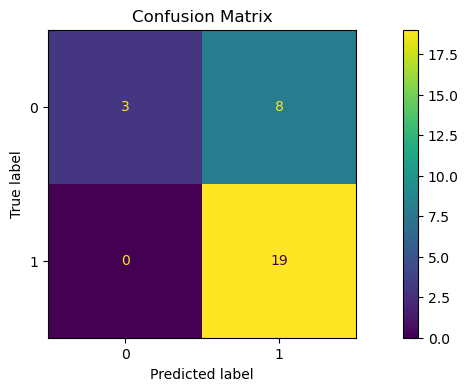

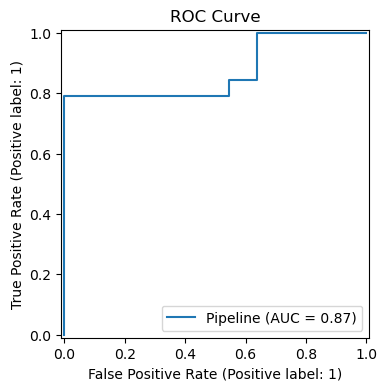

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': None, 'classifier__n_estimators': 175}
Best cross-validation score: 0.8341494435612082


In [29]:
# Grid search results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = grid_search.best_estimator_
y_pred = model_randforest.predict(X_test_transformed)
classification_metrics(model_randforest, X_test_transformed, y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


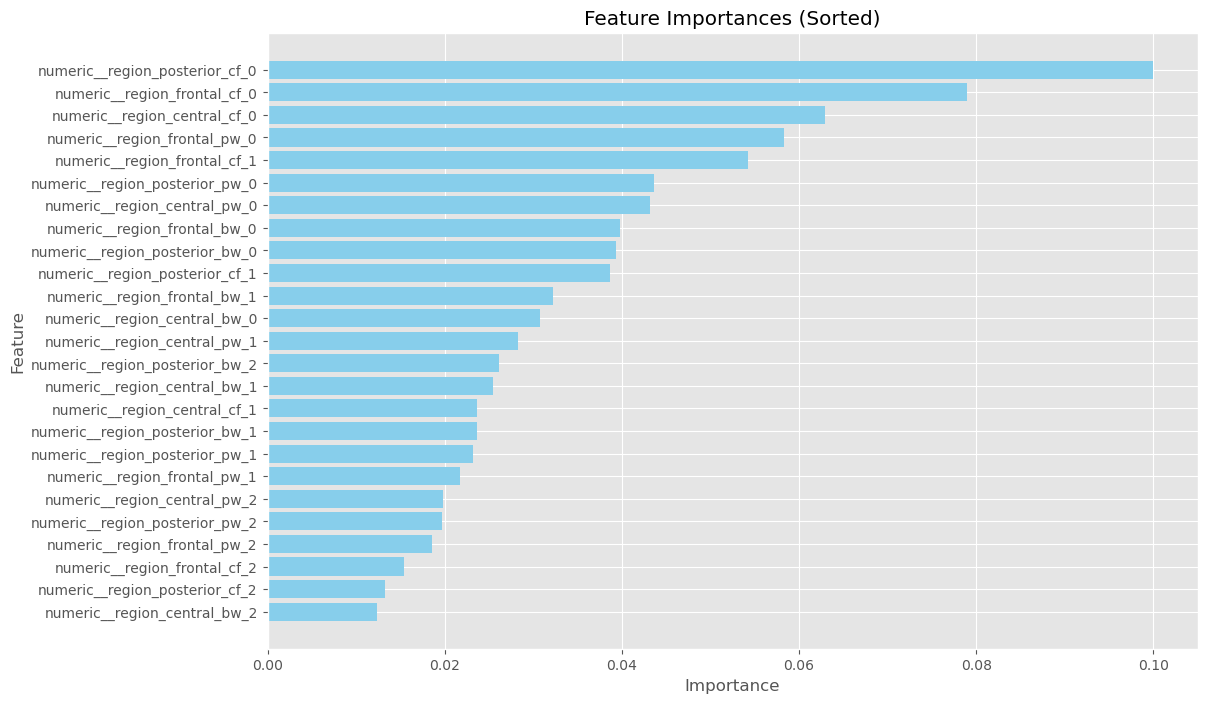

In [25]:
# Get feature importances
importances = model_randforest.named_steps['classifier'].feature_importances_

# Map feature importances to transformed feature names
transformed_feature_names = cols_transform.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Keep only the top 25 most important features
importance_df = importance_df.head(25)

# print(importance_df)

# Plot the feature importances with names horizontally
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# 5. Model Training With Features Search

In [30]:
# Establish a Model Pipeline - With Features Search
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('features_select', FeatureSelection()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'features_select__features_detail_level': ['region', 'channel'],
    'features_select__selected_features': [['exp', 'offset'], ['cf', 'pw', 'bw']],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 10, None],                       # Default none, unlimited
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']
                            # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

grid_search = GridSearchCV(
    model_pipeline, grid_params, 
    cv=5,
    scoring='f1'
    )


In [31]:
# Grid search run

start_time = time.perf_counter()
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time



------- Search Results --------
Score: 0.8488. Mean: 0.8032 and STD 0.0177
Search Took: 81.72 seconds
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_leaf_nodes': None, 'classifier__n_estimators': 150, 'features_select__features_detail_level': 'region', 'features_select__selected_features': ['cf', 'pw', 'bw']}
Top 10 out of 144 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
41,1,0.848778,0.088368,0.015493,"{'classifier__criterion': 'gini', 'classifier_..."
73,2,0.838123,0.087527,0.014345,"{'classifier__criterion': 'entropy', 'classifi..."
121,2,0.838123,0.085622,0.014668,"{'classifier__criterion': 'log_loss', 'classif..."
77,4,0.835199,0.100428,0.015625,"{'classifier__criterion': 'entropy', 'classifi..."
141,4,0.835199,0.096693,0.014309,"{'classifier__criterion': 'log_loss', 'classif..."
93,4,0.835199,0.098508,0.015725,"{'classifier__criterion': 'entropy', 'classifi..."
125,4,0.835199,0.126198,0.016672,"{'classifier__criterion': 'log_loss', 'classif..."
25,8,0.834901,0.086510,0.015108,"{'classifier__criterion': 'gini', 'classifier_..."
29,9,0.833309,0.093574,0.014810,"{'classifier__criterion': 'gini', 'classifier_..."
45,9,0.833309,0.099828,0.014967,"{'classifier__criterion': 'gini', 'classifier_..."


Accuracy: 0.6333
Precision: 0.6429
Recall: 0.9474
F1 Score 0.7660
Specificity: 0.0909
Hamming Loss 0.3667
Fall Out (FPR): 0.9091
ROC-AUC Score 0.8230
Gini Index: 0.6459


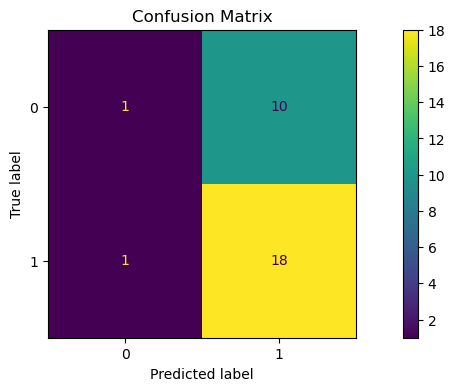

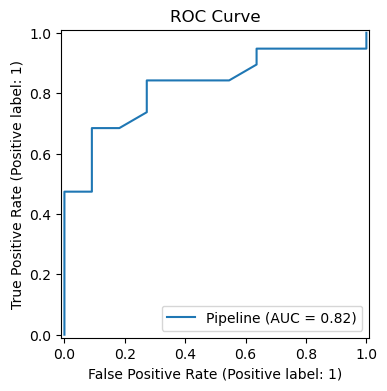

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_leaf_nodes': None, 'classifier__n_estimators': 150, 'features_select__features_detail_level': 'region', 'features_select__selected_features': ['cf', 'pw', 'bw']}
Best cross-validation score: 0.8487778887778887


In [32]:
# Grid search results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = grid_search.best_estimator_
y_pred = model_randforest.predict(X_test)
classification_metrics(model_randforest, X_test, y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
